# Feature extraction
Generating final outputs based on labelled vocabulary and preprocessed tweet data.
1. Frequency of topics
2. New words and their amount
3. Co-occurrence of topics
Additionally, grafics, tweet number statistics, lists of labelled words

In [1]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk import bigrams
import numpy as np
import itertools

In [2]:
def print_df_infos(movement_df, movement):
    len_df = len(movement_df)
    n_accs = len(set(movement_df["user.screen_name"]))
    print(f"{movement}: {len_df} tweets from {n_accs} accounts")

In [68]:
movements = ["demsoc","nhs","sunrise","xr"]

In [4]:
movement_dictionary = {
    "demsoc": "DSA",
    "nhs": "KONP",
    "sunrise": "Sunrise",
    "xr": "XR UK"
}

# I. Outputting vocabularies to manually identify relevant word blocks

In [5]:
from collections import Counter

In [6]:
def print_corpus_vocab(movement_name):
    with open(f'data/{movement_name}_preprocessed', 'rb') as file:
        df = pickle.load(file)
    corpus = list(df['text_preprocessed'])
    flat_corpus = [item for sublist in corpus for item in sublist]
    counter_obj = Counter(flat_corpus)
    frequencies = counter_obj.most_common()
    vocab_df = pd.DataFrame(frequencies, columns=["word","frequency"])
    vocab_df.to_csv(f"data/lists/{movement_name}_vocab.csv",sep=";")

In [22]:
for movement in movements:
    print_corpus_vocab(movement)

In [38]:
def print_labels(labeled_vocab, movement, policies):
    label_stats = {}
    for policy in policies:
        pol_labels = labeled_vocab[labeled_vocab["category"]==policy]
        length = len(pol_labels)
        words = ", ".join(pol_labels["word"])
        label_stats[policy] = (words,length)
    stats_df = pd.DataFrame.from_dict(label_stats).transpose()
    stats_df = stats_df.rename(columns={0:"words",1:"number"})
    
    stats_df.to_csv(f"data/outputs/{movement}_label_stats.csv",sep=";", decimal=",")

# II. Load labelled vocabs back in and do stuff

## 1. Frequency
Relative per Document Frequency of Policy Words
What percentage of tweets contain at least one of these words

In [36]:
def get_policy_count(week_corpus, policy_words, len_df):
    policy_count = 0
    for text in week_corpus['text_preprocessed']:
        val = any(ele in text for ele in policy_words)
        if val:
            policy_count += 1
    policy_count = (policy_count/len_df)*100
    return policy_count

In [52]:
def get_weekly_freq(week_corpus, labeled_vocab, policies, week_number):
    week_dict = {}
    len_week_corpus = len(week_corpus)
    for policy in policies:
        policy_words = list(labeled_vocab["word"][labeled_vocab["category"] ==policy])
        week_dict[policy] = get_policy_count(week_corpus, policy_words, len_week_corpus)
    week_df = pd.DataFrame.from_dict(week_dict, orient="index", columns=[f"week_{week_number}"])
    return week_df

In [65]:
def save_frequencies(movement_df, labeled_vocab, movement, policies):
    """getting policy docfrequencies for all policies and saving the table"""
    initial_corpus = movement_df[movement_df["week_number"]==1]
    frequencies_initial = get_weekly_freq(initial_corpus, labeled_vocab, policies, 1)
    n_weeks = movement_df["week_number"].max() + 1
    for i in range(2,n_weeks):
        week_corpus = movement_df[movement_df["week_number"]==i]
        week_frequencies = get_weekly_freq(week_corpus, labeled_vocab, policies, i)
        frequencies_initial = frequencies_initial.join(week_frequencies)
    # print as csv
    frequencies_initial = frequencies_initial.convert_dtypes() 
    frequencies_initial.to_csv(f"data/outputs/{movement}_frequency.csv",sep=";", decimal=",")
    
    return frequencies_initial

In [72]:
def get_shift(df):
    """defining labels shift for visualizations"""
    max_value = df.max().max()
    if max_value > 40:
        shift = 1
    elif max_value > 10:
        shift = 0.5
    else:
        shift = 0.1
    return shift

In [73]:
def save_docfr_visualizations(docfr, movement):
    """taking and visualizing the policy docfreq table"""
    policies = ["health", "social","covid","climate"]
    rhetoric = ["urgency","agency", "possibility"]
    
    tcolors = ["tab:orange", "tab:blue","tab:red","tab:green"]
    rcolors = ["tab:red","tab:orange","tab:green"]

    # Policies
    plt.figure(figsize=(10,7))
    poldf = docfr[:4]
    shift = get_shift(docfr)
    for i, policy in enumerate(policies):
        plt.plot(docfr.loc[policy], "o-", label=policy, color=tcolors[i])
        plt.legend()
        plt.xticks(rotation=90)   
        for x,y in enumerate(docfr.loc[policy]):
            label = str(int(np.round(y)))
            plt.annotate(label,(x,y+shift))   
        plt.title(f"{movement_dictionary[movement]} - Document Frequency of Topics (percent)")

    plt.tight_layout()
    plt.savefig(f"data/plots/{movement}_docfr_topics.jpg", pad_inches=1)

    # Rhetoric
    plt.figure(figsize=(10,7))
    retdf = docfr[4:]
    shift = get_shift(retdf)
    for i, policy in enumerate(rhetoric):
        plt.plot(docfr.loc[policy], "o-", label=policy, color=rcolors[i])
        plt.legend()
        plt.xticks(rotation=90)
        for x,y in enumerate(docfr.loc[policy]):
            label = str(int(np.round(y)))
            plt.annotate(label,(x,y+shift))
        plt.title(f"{movement_dictionary[movement]} - Document Frequency of Rhetorical elements (percent)")

    plt.tight_layout()
    plt.savefig(f"data/plots/{movement}_docfr_rhetoric.jpg", pad_inches=1)

# 2. New words
New words for each period compared to the past; and their amount

In [45]:
def save_new_words(movement_df, labeled_vocab, movement):
    """take tweets and labeled vocab and return new words for each week"""
    policy_words = labeled_vocab[~labeled_vocab["category"].isna() & ~(labeled_vocab["category"]=="stopword")]
    old = movement_df[movement_df['week_number']==1].reset_index(drop=True)
    last_week = movement_df["week_number"].max()
    newwords_df = pd.DataFrame()
    for week in list(range(2,last_week+1)):
        new_week = movement_df[movement_df['week_number']==week].reset_index(drop=True)
        old_vocab = list(itertools.chain.from_iterable(old['text_preprocessed']))
        new_vocab = list(itertools.chain.from_iterable(new_week['text_preprocessed']))
        new = set(new_vocab) - set(old_vocab)
        new_words = policy_words[policy_words["word"].isin(new)].reset_index(drop=True)
        new_dict = {}
        for name, group in new_words.groupby("category"):
            category = name
            words = list(group["word"])
            new_dict[f"{category}_words"] =  ", ".join(words)
            new_dict[f"{category}"] = len(words)
        week_row = pd.DataFrame(new_dict, index=[f"week_{week}"])
        newwords_df = newwords_df.append(week_row)
        old = old.append(new_week)
    
    newwords_df = newwords_df.fillna(0)
    newwords_df = newwords_df.convert_dtypes() 
    
    newwords_df.to_csv(f"data/outputs/{movement}_newwords_week.csv",sep=";", decimal=",")
    
    return newwords_df

In [56]:
def save_newword_visualizations(newwords_df, movement):
    policies = ["health", "social","covid","climate"]
    rhetoric = ["urgency","agency", "possibility"]
    
    tcolors = ["tab:orange", "tab:blue","tab:red","tab:green"]
    rcolors = ["tab:red","tab:orange","tab:green"]
    
    # Topics
    plt.figure(figsize=(10,7))
    poldf = newwords_df[policies]
    shift = get_shift(poldf)
    for i, policy in enumerate(policies):
        plt.plot(newwords_df[policy].values, "o-", label=policy, color=tcolors[i])
        plt.legend()
        for x,y in enumerate(newwords_df[policy]):
            label = str(int(np.round(y)))
            plt.annotate(label,(x,y+shift))   
        plt.title(f"{movement_dictionary[movement]} - New Words per Topics (number)")
    
    n_weeks = len(newwords_df[policy].values)+1
    ticks = [x for x in range(0,n_weeks)]
    labels = list(newwords_df.index)
    plt.xticks(ticks, labels=labels, rotation=90)
    plt.tight_layout()
    plt.savefig(f"data/plots/{movement}_newwords_topics.jpg", pad_inches=1)

    # Rhetoric
    rhetdf = newwords_df[rhetoric]
    shift = get_shift(rhetdf)
    plt.figure(figsize=(10,7))
    for i, policy in enumerate(rhetoric):
        plt.plot(newwords_df[policy].values, "o-", label=policy, color=rcolors[i])
        plt.legend()
        for x,y in enumerate(newwords_df[policy]):
            label = str(int(np.round(y)))
            plt.annotate(label,(x,y+shift))   
        plt.title(f"{movement_dictionary[movement]} - New Words per Rhetorical Element (number)")
    
    n_weeks = len(newwords_df[policy].values)+1
    ticks = [x for x in range(0,n_weeks)]
    labels = list(newwords_df.index)
    plt.xticks(ticks, labels=labels, rotation=90)
    plt.tight_layout()
    plt.savefig(f"data/plots/{movement}_newwords_rhetoric.jpg", pad_inches=1)

# 3. Co-occurrence
Simultaneous occurrence of two topics in a document - relative percentual rate

In [47]:
def gen_word_cooccurrence(df, labeled_vocab, policies):
    """takes tweet df and labeled vocab, returns co-occurence
    (in terms of being in the same doc) of policy words"""
    # Out of policy words, generate a list of all possible bigrmas
    vocab = list(labeled_vocab["word"][labeled_vocab["category"].isin(policies)])
    vocab_index = {word: i for i, word in enumerate(vocab)}
    policy_bigrams = list(itertools.combinations(vocab, 2))
    # For each tweet, output all possible word combis as bigrams
    tweets = list(df["text_preprocessed"])
    all_bigrams = []
    for tweet in tweets:
        tweet_vocab = set(tweet)
        tweet_combis = list(itertools.combinations(tweet_vocab, 2))
        all_bigrams.extend(tweet_combis)
    # Count frequencies in the resulting bigram list
    bigram_frequencies = nltk.FreqDist(all_bigrams)
    frequencies_df = pd.DataFrame(list(bigram_frequencies.items()), columns = ["bigrams","frequency"]) 
    # Subset df to relevant words only
    policy_frequencies_df = frequencies_df[frequencies_df["bigrams"].isin(policy_bigrams)].reset_index(drop=True)
    # Find a list of existing bigrams in policy frequencies df
    existing_bigrams = list(policy_frequencies_df["bigrams"])
    # Generate a co-occurrence matrix
    co_occurrence_matrix = np.zeros((len(vocab), len(vocab)))
    # Loop through the existing bigrams taking the current and previous word,
    # and the number of occurrences of the bigram.
    for bigram in existing_bigrams:
        current = bigram[0]
        previous = bigram[1]
        count = policy_frequencies_df[policy_frequencies_df["bigrams"]==bigram]["frequency"].values[0]
        pos_current = vocab_index[current]
        pos_previous = vocab_index[previous]
        co_occurrence_matrix[pos_current][pos_previous] = count
    co_occurrence_matrix = np.matrix(co_occurrence_matrix)
    # Add names
    co_occurrence_matrix = pd.DataFrame(co_occurrence_matrix, index=vocab_index,
                             columns=vocab_index)
    
    return co_occurrence_matrix

In [48]:
def get_block_cooc(cooc_df, labeled_vocab, policies, rowname):
    """Takes an absolute word cooc df for a given time unit and returns absolute block cooc df"""
    cooc_dict = {}
    for policy in policies:
        policy_words = list(labeled_vocab["word"][labeled_vocab["category"] ==policy])
        policy_cooc = cooc_df[policy_words]
        for second_policy in policies:
            second_policy_words = list(labeled_vocab["word"][labeled_vocab["category"] ==second_policy])
            two_policies_cooc = policy_cooc[policy_cooc.index.isin(second_policy_words)]
            two_policies_cooc = two_policies_cooc.sum().sum()
            reversed_name = f"{second_policy}-{policy}"
            if reversed_name in cooc_dict.keys():
                cooc_dict[reversed_name] += two_policies_cooc
            else:
                cooc_name = f"{policy}-{second_policy}"
                cooc_dict[cooc_name] = two_policies_cooc
    block_cooc_df = pd.DataFrame(cooc_dict, index=[rowname])
    return block_cooc_df

In [49]:
def save_cooc(movement_df, labeled_vocab, policies):
    """Saves a comparison df for all weeks (absolute and percent-normalized block cooc)"""
    # Initialize the comparison df and normalized comparison df
    comparison = pd.DataFrame()
    comparison_normalized = pd.DataFrame()
    n_weeks = movement_df["week_number"].max() + 1
    # Iterate over weeks and generate block cooc dfs, append them to comparison
    for i in range(1,n_weeks):
        week_corpus = movement_df[movement_df["week_number"]==i]
        week_cooc = gen_word_cooccurrence(week_corpus, labeled_vocab, policies)
        week_block_cooc = get_block_cooc(week_cooc, labeled_vocab, policies, f"week_{i}")
        comparison = comparison.append(week_block_cooc)
        # Normalize the week row by n of tweets
        n_tweets_week = len(week_corpus)
        week_block_cooc_norm = (week_block_cooc/n_tweets_week)*100
        comparison_normalized = comparison_normalized.append(week_block_cooc_norm)
    # Save normalized comparison
    comparison_normalized.to_csv(f"data/outputs/{movement}_cooccurrence.csv",sep=";", decimal=",")
    
    return comparison_normalized

In [63]:
def visualize_topic_cooc(cooc, topic, movement):
    """Takes co-occurrence matrix, visualises topic and rhetoric co-occurrence for a given topic"""
    policies = ["health", "social","covid","climate"]
    rhetoric = ["urgency","agency", "possibility"]
    # Find columns for cooccurrence of the topic with other topics and rhet.els
    topic_topic_columns = [x for x in cooc.columns if topic in x]
    topic_rhetoric_columns = topic_topic_columns.copy()
    for element in rhetoric:
        topic_topic_columns = [c for c in topic_topic_columns if element not in c]
    relevant_columns = [x for x in cooc.columns if topic in x]
    topic_rhetoric_columns = list(set(relevant_columns) - set(topic_topic_columns))
    # Get corresponding subdataframes
    topic_topic_cooc = cooc[topic_topic_columns]
    topic_rhetoric_cooc = cooc[topic_rhetoric_columns]
    # Visualize and save both dataframes
    # Topic topic
    shift = get_shift(topic_topic_cooc)
    plt.figure(figsize=(10,7))
    for i, policy in enumerate(topic_topic_cooc.columns):
        plt.plot(topic_topic_cooc[policy].values, "o-", label=policy)
        plt.legend()
        for x,y in enumerate(topic_topic_cooc[policy]):
            label = str(int(np.round(y)))
            plt.annotate(label,(x,y+shift))   
        plt.title(f"{movement_dictionary[movement]} - Co-occurrence of policies with '{topic}' (percent)")
    
    n_weeks = len(topic_topic_cooc[policy].values)+1
    ticks = [x for x in range(0,n_weeks)]
    labels = list(topic_topic_cooc.index)
    plt.xticks(ticks, labels=labels, rotation=90)
    plt.tight_layout()
    plt.savefig(f"data/plots/{movement}_cooc_{topic}_topic.jpg", pad_inches=1)
    
    # Topic rhetoric
    shift = get_shift(topic_rhetoric_cooc)
    plt.figure(figsize=(10,7))
    for i, policy in enumerate(topic_rhetoric_cooc.columns):
        plt.plot(topic_rhetoric_cooc[policy].values, "o-", label=policy)
        plt.legend()
        for x,y in enumerate(topic_rhetoric_cooc[policy]):
            label = str(int(np.round(y)))
            plt.annotate(label,(x,y+shift))   
        plt.title(f"{movement_dictionary[movement]} - Co-occurrence of rhetorical elements with '{topic}' (percent)")
    
    n_weeks = len(topic_rhetoric_cooc[policy].values)+1
    ticks = [x for x in range(0,n_weeks)]
    labels = list(topic_rhetoric_cooc.index)
    plt.xticks(ticks, labels=labels, rotation=90)
    plt.tight_layout()
    plt.savefig(f"data/plots/{movement}_cooc_{topic}_rhetoric.jpg", pad_inches=1)
    

In [51]:
def visualize_cooc(cooc, movement):
    """Iterates over all topics for co-occurrence visualization"""
    topics = ["health", "social","covid","climate"]
    rhetoric = ["urgency","agency", "possibility"]
    
    for topic in topics:
        visualize_topic_cooc(cooc, topic, movement)

In [55]:
docfr

,week_1,week_2,week_3,week_4,week_5,week_6,week_7,week_8,week_9,week_10,...,week_17,week_18,week_19,week_20,week_21,week_22,week_23,week_24,week_25,week_26
social,30.216490,28.493035,25.010855,26.102941,20.313695,24.391989,27.098997,25.799173,23.720137,21.003764,...,45.641730,49.016100,35.564854,37.801802,40.655867,67.578880,43.414634,37.242614,39.306059,19.243986
covid,0.967296,1.857324,1.650022,0.661765,1.071155,0.393419,0.845865,1.353892,1.621160,0.953576,...,33.241821,27.280859,19.157203,19.279279,21.928092,22.923374,20.341463,16.025067,17.814604,9.879725
health,9.120221,8.906712,8.640903,6.544118,5.049732,6.831187,9.085213,11.169613,8.233788,5.395232,...,14.161519,17.382230,8.188882,10.954955,8.099565,9.529942,10.975610,13.428827,9.580528,5.047251
climate,11.469369,8.146897,7.164568,11.691176,5.967865,7.403433,9.085213,4.400150,7.380546,4.341280,...,2.859757,2.355397,5.349671,4.504505,18.569735,5.505473,6.585366,6.714414,5.178664,2.577320
urgency,16.720405,16.082735,14.242293,18.750000,16.335119,16.738197,13.377193,13.802181,14.035836,13.701380,...,32.486845,30.083482,27.106993,22.486486,25.839589,23.341919,22.439024,22.739481,21.439669,17.010309
agency,40.672501,36.217813,35.128094,26.250000,39.135425,41.702432,36.998747,35.539677,35.793515,34.303639,...,37.176847,38.282648,53.197848,49.621622,48.478862,51.545396,41.170732,43.912265,44.277576,47.358247
possibility,8.797789,9.793162,10.334347,10.808824,10.673298,8.011445,8.333333,9.890936,10.665529,13.425345,...,6.954930,7.990459,12.641961,8.432432,11.418412,8.209916,8.487805,10.877350,6.473330,8.311856


## FINAL: Iteration over all, generate outputs

xr: 63099 tweets from 138 accounts


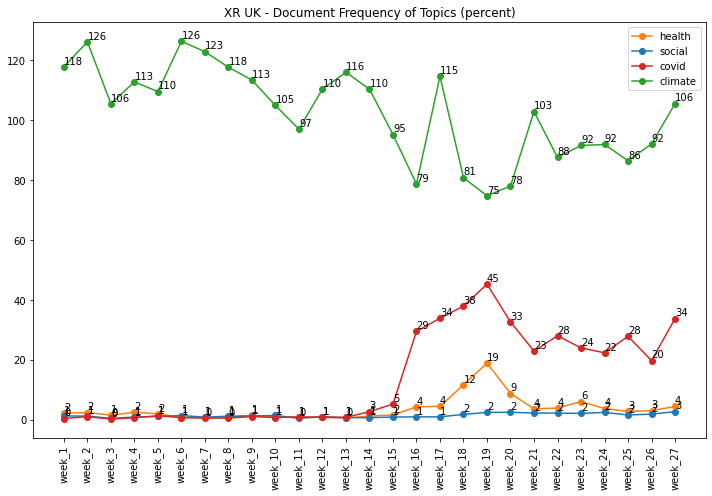

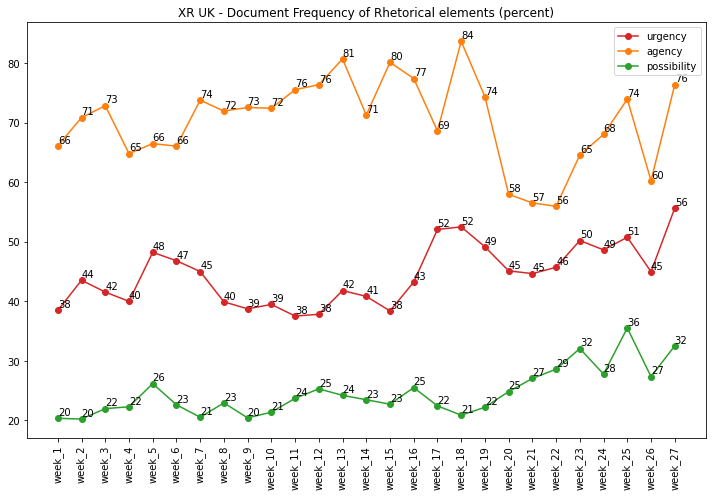

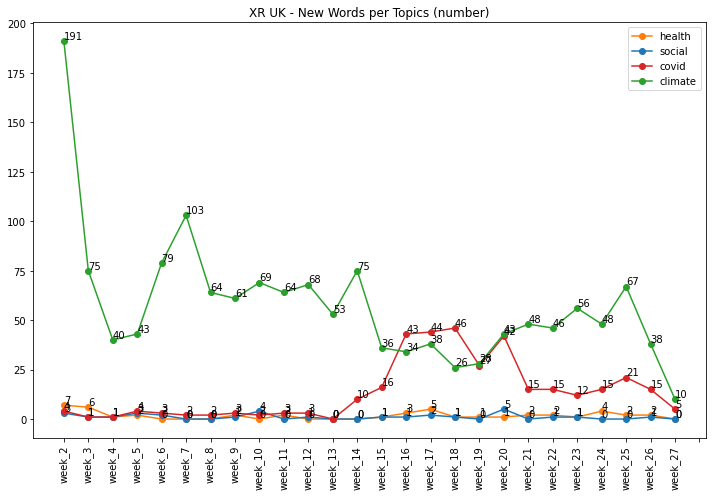

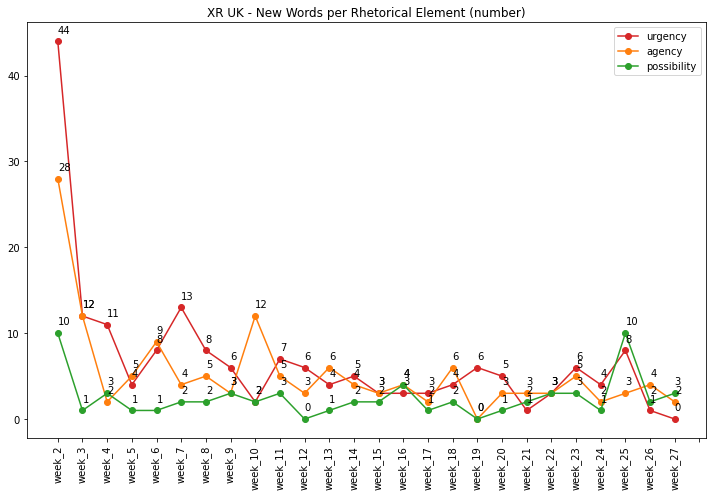

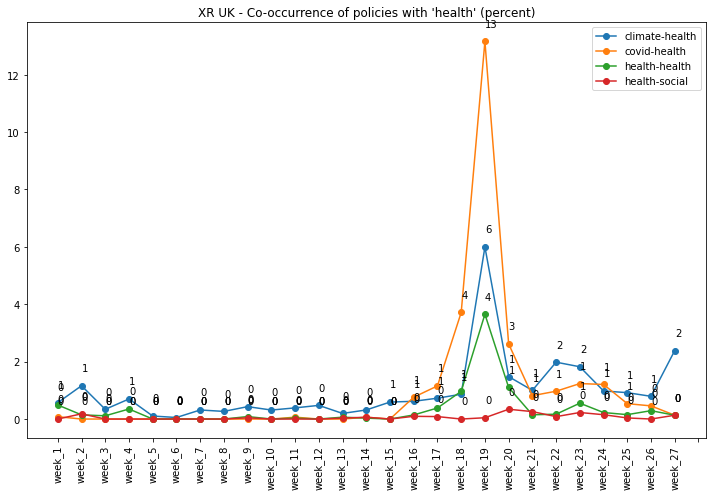

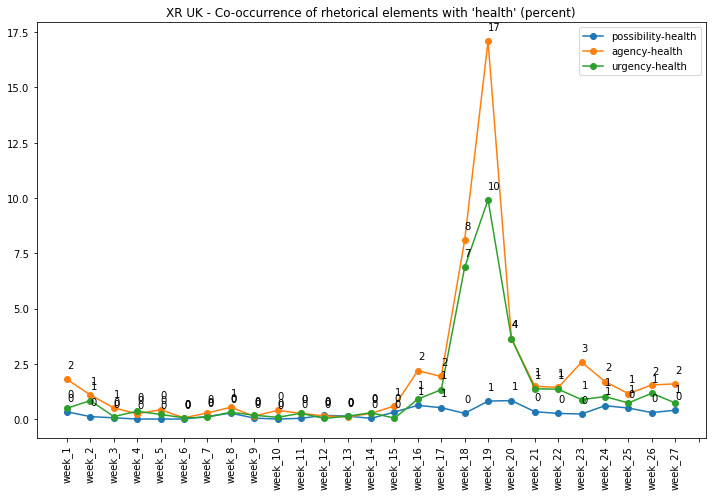

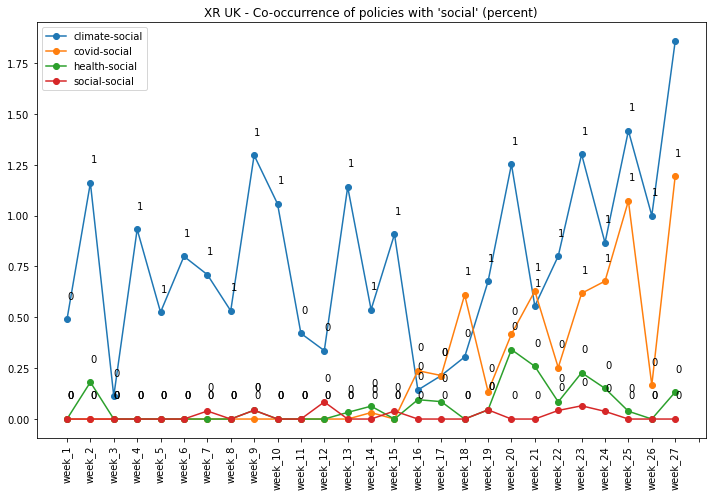

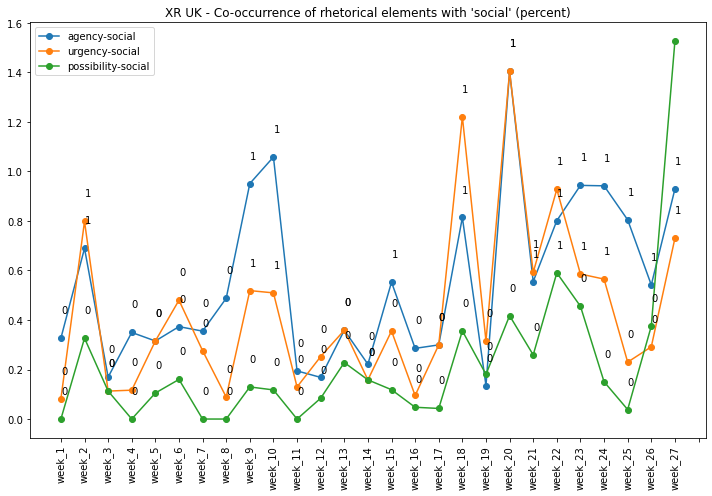

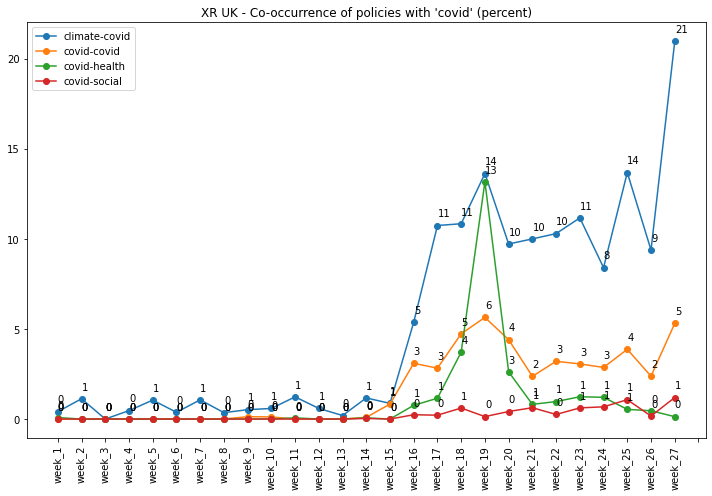

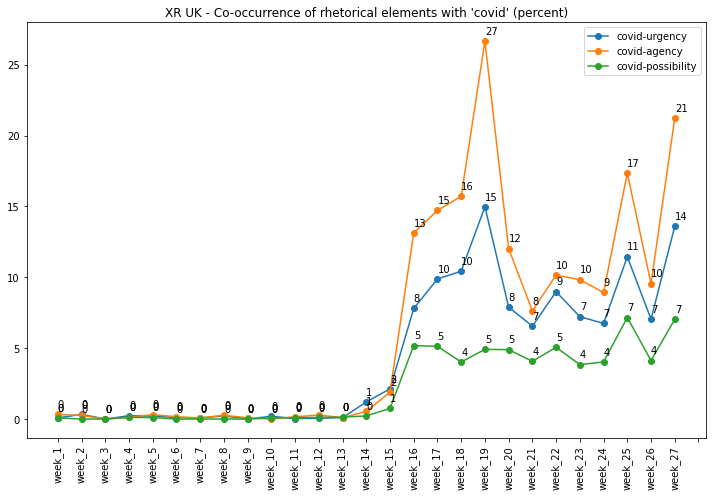

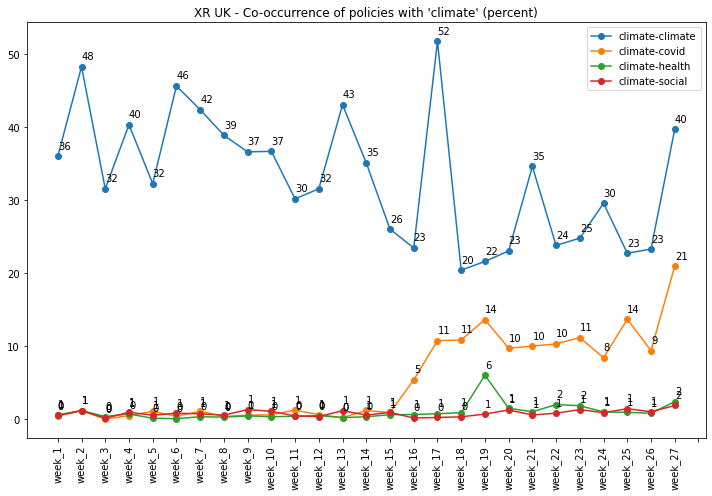

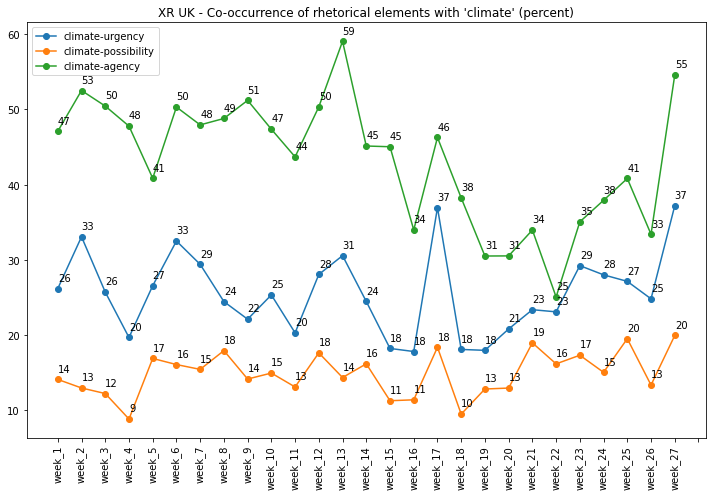

In [75]:
# Iterate over all movements and policies and generate outputs
for movement in movements:
    # load tweets
    with open(f'data/{movement}_preprocessed', 'rb') as file:
        movement_df = pickle.load(file)
    # load labelled vocabulary and get list of policies
    labeled_vocab = pd.read_csv(f'data/lists/{movement}_vocab_labeled.csv',";")
    policies = list(labeled_vocab["category"].value_counts().index)
    policies.remove("stopword")
    # 0. print label stats
    print_labels(labeled_vocab, movement, policies)
    # 1. save relative document frequencies and visualizations
    docfr = save_frequencies(movement_df, labeled_vocab, movement, policies)
    save_docfr_visualizations(docfr, movement)
    # 2. save and visualize new words
    newwords_df = save_new_words(movement_df, labeled_vocab, movement)
    save_newword_visualizations(newwords_df, movement)
    # 3. save policy word co-occurrences
    cooc = save_cooc(movement_df, labeled_vocab, policies)
    visualize_cooc(cooc, movement)
    # 4. print df statistics
    print_df_infos(movement_df, movement)